# Node Embeddings

This notebook demonstrates different methods for node embeddings and how to further reduce their dimensionality to be able to visualize them in a 2D plot. 

Node embeddings are essentially an array of floating point numbers (length = embedding dimension) that can be used as "features" in machine learning. These numbers approximate the relationship and similarity information of each node and can also be seen as a way to encode the topology of the graph.

## Considerations

Due to dimensionality reduction some information gets lost, especially when visualizing node embeddings in two dimensions. Nevertheless, it helps to get an intuition on what node embeddings are and how much of the similarity and neighborhood information is retained. The latter can be observed by how well nodes of the same color and therefore same community are placed together and how much bigger nodes with a high centrality score influence them. 

If the visualization doesn't show a somehow clear separation between the communities (colors) here are some ideas for tuning: 
- Clean the data, e.g. filter out very few nodes with extremely high degree that aren't actually that important
- Try directed vs. undirected projections
- Tune the embedding algorithm, e.g. use a higher dimensionality
- Tune t-SNE that is used to reduce the node embeddings dimension to two dimensions for visualization. 

It could also be the case that the node embeddings are good enough and well suited the way they are despite their visualization for the down stream task like node classification or link prediction. In that case it makes sense to see how the whole pipeline performs before tuning the node embeddings in detail. 

## Note about data dependencies

PageRank centrality and Leiden community are also fetched from the Graph and need to be calculated first.
This makes it easier to see if the embeddings approximate the structural information of the graph in the plot.
If these properties are missing you will only see black dots all of the same size.

<br>  

### References
- [jqassistant](https://jqassistant.org)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)
- [Tutorial: Applied Graph Embeddings](https://neo4j.com/developer/graph-data-science/applied-graph-embeddings)
- [Visualizing the embeddings in 2D](https://github.com/openai/openai-cookbook/blob/main/examples/Visualizing_embeddings_in_2D.ipynb)
- [scikit-learn TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)
- [AttributeError: 'list' object has no attribute 'shape'](https://bobbyhadz.com/blog/python-attributeerror-list-object-has-no-attribute-shape)
- [Fast Random Projection (neo4j)](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp)
- [HashGNN (neo4j)](https://neo4j.com/docs/graph-data-science/2.6/machine-learning/node-embeddings/hashgnn)
- [node2vec (neo4j)](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/node2vec) computes a vector representation of a node based on second order random walks in the graph. 
- [Complete guide to understanding Node2Vec algorithm](https://towardsdatascience.com/complete-guide-to-understanding-node2vec-algorithm-4e9a35e5d147)

In [1]:
import os
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plot
import typing as typ
import numpy as np
from sklearn.manifold import TSNE
from neo4j import GraphDatabase

In [2]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The pandas version is {}.'.format(pd.__version__))


The scikit-learn version is 1.3.0.
The pandas version is 1.5.1.


In [3]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [4]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [5]:
def query_cypher_to_data_frame(filename, parameters_: typ.Optional[typ.Dict[str, typ.Any]] = None):
    records, summary, keys = driver.execute_query(get_cypher_query_from_file(filename),parameters_=parameters_)
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [6]:
def query_first_non_empty_cypher_to_data_frame(*filenames : str, parameters: typ.Optional[typ.Dict[str, typ.Any]] = None):
    """
    Executes the Cypher queries of the given files and returns the first result that is not empty.
    If all given file names result in empty results, the last (empty) result will be returned.
    By additionally specifying "limit=" the "LIMIT" keyword will appended to query so that only the first results get returned.
    """
    result=pd.DataFrame()
    for filename in filenames:
        result=query_cypher_to_data_frame(filename, parameters)
        if not result.empty:
            print("The results have been provided by the query filename: " + filename)
            return result
    return result

In [7]:
# TODO option to choose between directed and undirected projection

def create_undirected_projection(parameters: dict) -> bool: 
    """
    Creates an undirected homogenous in-memory Graph projection for/with Neo4j Graph Data Science Plugin.
    It returns True if there is data available for the given parameter and False otherwise.
    Parameters
    ----------
    dependencies_projection : str
        The name prefix for the in-memory projection for dependencies. Example: "java-package-embeddings-notebook"
    dependencies_projection_node : str
        The label of the nodes that will be used for the projection. Example: "Package"
    dependencies_projection_weight_property : str
        The name of the node property that contains the dependency weight. Example: "weight25PercentInterfaces"
    dependencies_projection_embedding_dimension : str
        The number of the dimensions and therefore size of the resulting array of floating point numbers
    """
    
    is_data_missing=query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_0_Check_Projectable.cypher", parameters).empty
    if is_data_missing: return False

    query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_1_Delete_Projection.cypher", parameters)
    query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_2_Delete_Subgraph.cypher", parameters)
    # To include the direction of the relationships use the following line to create the projection:
    # query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_3_Create_Projection.cypher", parameters)
    query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_4_Create_Undirected_Projection.cypher", parameters)
    query_cypher_to_data_frame("../cypher/Dependencies_Projection/Dependencies_5_Create_Subgraph.cypher", parameters)
    return True

In [8]:
# Feature ideas
# TODO option to choose between directed and undirected projection
# TODO option to not read already existing node embeddings to experiment with different (hpyer) parameters
# TODO run a community detection algorithm co-located in here when "communityId" is missing
# TODO run a centrality algorithm co-located in here when "centrality" score is missing

def create_node_embeddings(cypher_file_name: str, parameters: dict) -> pd.DataFrame: 
    """
    Creates an in-memory Graph projection by calling "create_undirected_projection", 
    runs the cypher Query given as cypherFileName parameter to calculate and stream the node embeddings
    and returns a DataFrame with the results.
    
    cypher_file_name
    ----------
    Name of the file containing the Cypher query that executes node embeddings procedure.

    parameters
    ----------
    dependencies_projection : str
        The name prefix for the in-memory projection for dependencies. Example: "java-package-embeddings-notebook"
    dependencies_projection_node : str
        The label of the nodes that will be used for the projection. Example: "Package"
    dependencies_projection_weight_property : str
        The name of the node property that contains the dependency weight. Example: "weight25PercentInterfaces"
    dependencies_projection_embedding_dimension : str
        The number of the dimensions and therefore size of the resulting array of floating point numbers
    """
    
    is_data_available=create_undirected_projection(parameters)
    
    if not is_data_available:
        print("No projected data for node embeddings calculation available")
        empty_result = pd.DataFrame(columns=["codeUnitName", 'projectName', 'communityId', 'centrality', 'embedding'])
        return empty_result

    existing_embeddings_query_filename="../cypher/Node_Embeddings/Node_Embeddings_0a_Query_Calculated.cypher"
    embeddings = query_first_non_empty_cypher_to_data_frame(existing_embeddings_query_filename, cypher_file_name, parameters=parameters)
    display(embeddings.head()) # Display the first entries of the table
    return embeddings

### Dimensionality reduction with t-distributed stochastic neighbor embedding (t-SNE)

The following function takes the original node embeddings with a higher dimensionality, e.g. 64 floating point numbers, and reduces them into a two dimensional array for visualization. 

> It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

(see https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)

In [9]:
def prepare_node_embeddings_for_2d_visualization(embeddings: pd.DataFrame) -> pd.DataFrame:
    """
    Reduces the dimensionality of the node embeddings (e.g. 64 floating point numbers in an array)
    to two dimensions for 2D visualization.
    see https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE
    """

    if embeddings.empty: 
        print("No projected data for node embeddings dimensionality reduction available")
        return embeddings
    
    # Calling the fit_transform method just with a list doesn't seem to work (anymore?). 
    # It leads to an error with the following message: 'list' object has no attribute 'shape'
    # This can be solved by converting the list to a numpy array using np.array(..).
    # See https://bobbyhadz.com/blog/python-attributeerror-list-object-has-no-attribute-shape
    embeddings_as_numpy_array = np.array(embeddings.embedding.to_list())

    # Use t-distributed stochastic neighbor embedding (t-SNE) to reduce the dimensionality 
    # of the previously calculated node embeddings to 2 dimensions for visualization
    t_distributed_stochastic_neighbor_embedding = TSNE(n_components=2, verbose=1, random_state=50)
    two_dimension_node_embeddings = t_distributed_stochastic_neighbor_embedding.fit_transform(embeddings_as_numpy_array)
    display(two_dimension_node_embeddings.shape) # Display the shape of the t-SNE result

    # Create a new DataFrame with the results of the 2 dimensional node embeddings
    # and the code unit and artifact name of the query above as preparation for the plot
    node_embeddings_for_visualization = pd.DataFrame(data = {
        "codeUnit": embeddings.codeUnitName,
        "artifact": embeddings.projectName,
        "communityId": embeddings.communityId,
        "centrality": embeddings.centrality,
        "x": [value[0] for value in two_dimension_node_embeddings],
        "y": [value[1] for value in two_dimension_node_embeddings]
    })
    display(node_embeddings_for_visualization.head()) # Display the first line of the results
    return node_embeddings_for_visualization
    

In [10]:
def plot_2d_node_embeddings(node_embeddings_for_visualization: pd.DataFrame, title: str):
    if embeddings.empty:
        print("No projected data to plot available")
        return

    plot.scatter(
        x=node_embeddings_for_visualization.x,
        y=node_embeddings_for_visualization.y,
        s=node_embeddings_for_visualization.centrality * 300,
        c=node_embeddings_for_visualization.communityId,
        cmap=main_color_map,
    )
    plot.title(title)
    plot.show()

In [11]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [12]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [13]:
# Main Colormap
main_color_map = 'nipy_spectral'

## 1. Java Packages

### 1.1 Generate Node Embeddings using Fast Random Projection (Fast RP) for Java Packages

[Fast Random Projection](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp) is used to reduce the dimensionality of the node feature space while preserving most of the distance information. Nodes with similar neighborhood result in node embedding with similar vectors.

In [14]:
java_package_embeddings_parameters={
    "dependencies_projection": "java-package-embeddings-notebook",
    "dependencies_projection_node": "Package",
    "dependencies_projection_weight_property": "weight25PercentInterfaces",
    "dependencies_projection_write_property": "embeddingsFastRandomProjection",
    "dependencies_projection_embedding_dimension":"32"
}
embeddings = create_node_embeddings("../cypher/Node_Embeddings/Node_Embeddings_1d_Fast_Random_Projection_Stream.cypher", java_package_embeddings_parameters)


The results have been provided by the query filename: ../cypher/Node_Embeddings/Node_Embeddings_0a_Query_Calculated.cypher


,codeUnitName,shortCodeUnitName,projectName,communityId,centrality,embedding
0,org.axonframework.modelling.command,command,axon-modelling-4.9.3,0,0.155609,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4744147062301636, ..."
1,org.axonframework.modelling.command.inspection,inspection,axon-modelling-4.9.3,0,0.152740,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.44183439016342163,..."
2,org.axonframework.modelling.command.legacyjpa,legacyjpa,axon-modelling-4.9.3,0,0.016234,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.48884743452072144,..."
3,org.axonframework.modelling.saga,saga,axon-modelling-4.9.3,1,0.349429,"[0.547947108745575, 0.0, -0.2763155996799469, ..."
4,org.axonframework.modelling.saga.metamodel,metamodel,axon-modelling-4.9.3,1,0.315690,"[0.6282529234886169, 0.0, -0.3879297971725464,..."


### 1.2 Dimensionality reduction with t-distributed stochastic neighbor embedding (t-SNE)

This step takes the original node embeddings with a higher dimensionality, e.g. 64 floating point numbers, and reduces them into a two dimensional array for visualization. For more details look up the function declaration for "prepare_node_embeddings_for_2d_visualization".

In [15]:
node_embeddings_for_visualization = prepare_node_embeddings_for_2d_visualization(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.000s...
[t-SNE] Computed neighbors for 93 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 0.643282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.059189
[t-SNE] KL divergence after 800 iterations: 0.089308


(93, 2)

,codeUnit,artifact,communityId,centrality,x,y
0,org.axonframework.modelling.command,axon-modelling-4.9.3,0,0.155609,-2.316905,1.645078
1,org.axonframework.modelling.command.inspection,axon-modelling-4.9.3,0,0.152740,-2.315709,1.656115
2,org.axonframework.modelling.command.legacyjpa,axon-modelling-4.9.3,0,0.016234,-2.313216,1.677108
3,org.axonframework.modelling.saga,axon-modelling-4.9.3,1,0.349429,-3.741343,-4.053920
4,org.axonframework.modelling.saga.metamodel,axon-modelling-4.9.3,1,0.315690,-3.821021,-4.334672


### 1.3 Visualization of the node embeddings reduced to two dimensions

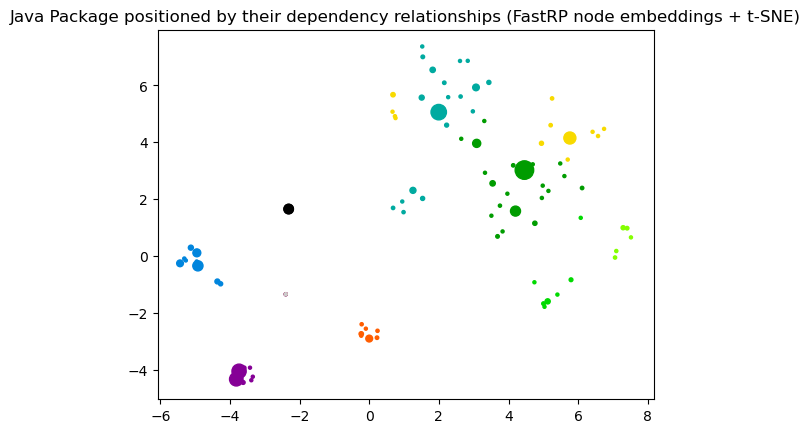

In [16]:
plot_2d_node_embeddings(
    node_embeddings_for_visualization, 
    "Java Package positioned by their dependency relationships (FastRP node embeddings + t-SNE)"
)

### 1.4 Node Embeddings for Java Packages using HashGNN

[HashGNN](https://neo4j.com/docs/graph-data-science/2.6/machine-learning/node-embeddings/hashgnn) resembles Graph Neural Networks (GNN) but does not include a model or require training. It combines ideas of GNNs and fast randomized algorithms. For more details see [HashGNN](https://neo4j.com/docs/graph-data-science/2.6/machine-learning/node-embeddings/hashgnn). Here, the latter 3 steps are combined into one for HashGNN.

The results have been provided by the query filename: ../cypher/Node_Embeddings/Node_Embeddings_0a_Query_Calculated.cypher


,codeUnitName,shortCodeUnitName,projectName,communityId,centrality,embedding
0,org.axonframework.modelling.command,command,axon-modelling-4.9.3,0,0.155609,"[0.4330126941204071, 0.4330126941204071, 0.0, ..."
1,org.axonframework.modelling.command.inspection,inspection,axon-modelling-4.9.3,0,0.152740,"[0.4330126941204071, 0.4330126941204071, 0.0, ..."
2,org.axonframework.modelling.command.legacyjpa,legacyjpa,axon-modelling-4.9.3,0,0.016234,"[0.4330126941204071, 0.4330126941204071, 0.0, ..."
3,org.axonframework.modelling.saga,saga,axon-modelling-4.9.3,1,0.349429,"[0.6495190411806107, -0.4330126941204071, -0.4..."
4,org.axonframework.modelling.saga.metamodel,metamodel,axon-modelling-4.9.3,1,0.315690,"[0.6495190411806107, -0.4330126941204071, -0.4..."


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.000s...
[t-SNE] Computed neighbors for 93 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 2.839166
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.048817
[t-SNE] KL divergence after 1000 iterations: -0.075532


(93, 2)

,codeUnit,artifact,communityId,centrality,x,y
0,org.axonframework.modelling.command,axon-modelling-4.9.3,0,0.155609,60.818573,95.293839
1,org.axonframework.modelling.command.inspection,axon-modelling-4.9.3,0,0.152740,60.818573,95.293839
2,org.axonframework.modelling.command.legacyjpa,axon-modelling-4.9.3,0,0.016234,60.818573,95.293839
3,org.axonframework.modelling.saga,axon-modelling-4.9.3,1,0.349429,10.671844,154.030533
4,org.axonframework.modelling.saga.metamodel,axon-modelling-4.9.3,1,0.315690,10.671844,154.030533


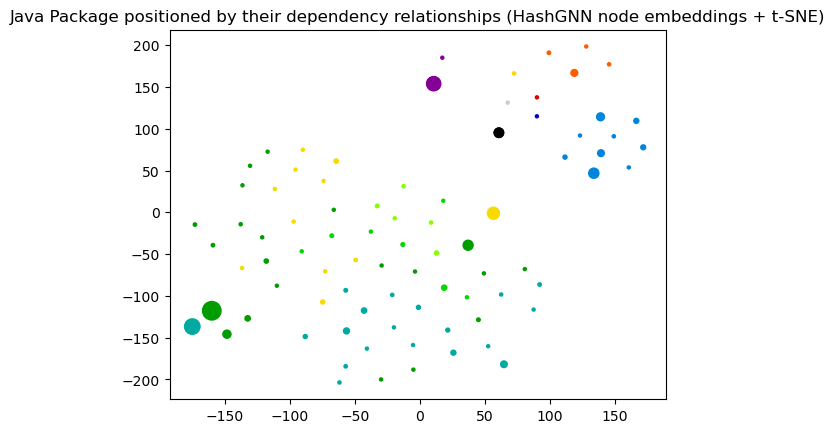

In [17]:
java_package_embeddings_parameters={
    "dependencies_projection": "java-package-embeddings-notebook",
    "dependencies_projection_node": "Package",
    "dependencies_projection_weight_property": "weight25PercentInterfaces",
    "dependencies_projection_write_property": "embeddingsHashGNN",
    "dependencies_projection_embedding_dimension":"64"
}
embeddings = create_node_embeddings("../cypher/Node_Embeddings/Node_Embeddings_2d_Hash_GNN_Stream.cypher", java_package_embeddings_parameters)
node_embeddings_for_visualization = prepare_node_embeddings_for_2d_visualization(embeddings)
plot_2d_node_embeddings(
    node_embeddings_for_visualization, 
    "Java Package positioned by their dependency relationships (HashGNN node embeddings + t-SNE)"
)

### 2.5 Node Embeddings for Java Packages using node2vec

The results have been provided by the query filename: ../cypher/Node_Embeddings/Node_Embeddings_0a_Query_Calculated.cypher


,codeUnitName,shortCodeUnitName,projectName,communityId,centrality,embedding
0,org.axonframework.modelling.command,command,axon-modelling-4.9.3,0,0.155609,"[1.5525641441345215, -0.050923220813274384, -0..."
1,org.axonframework.modelling.command.inspection,inspection,axon-modelling-4.9.3,0,0.152740,"[1.4184802770614624, -0.0715189278125763, -0.3..."
2,org.axonframework.modelling.command.legacyjpa,legacyjpa,axon-modelling-4.9.3,0,0.016234,"[1.4274920225143433, -0.05479925870895386, -0...."
3,org.axonframework.modelling.saga,saga,axon-modelling-4.9.3,1,0.349429,"[-0.30794599652290344, -0.529090404510498, 0.3..."
4,org.axonframework.modelling.saga.metamodel,metamodel,axon-modelling-4.9.3,1,0.315690,"[-0.30051910877227783, -0.5740488767623901, 0...."


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.000s...
[t-SNE] Computed neighbors for 93 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 0.684650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.476254
[t-SNE] KL divergence after 1000 iterations: 0.127669


(93, 2)

,codeUnit,artifact,communityId,centrality,x,y
0,org.axonframework.modelling.command,axon-modelling-4.9.3,0,0.155609,-4.675839,-2.867482
1,org.axonframework.modelling.command.inspection,axon-modelling-4.9.3,0,0.152740,-4.675829,-2.867575
2,org.axonframework.modelling.command.legacyjpa,axon-modelling-4.9.3,0,0.016234,-4.677393,-2.866932
3,org.axonframework.modelling.saga,axon-modelling-4.9.3,1,0.349429,-2.333180,-1.476808
4,org.axonframework.modelling.saga.metamodel,axon-modelling-4.9.3,1,0.315690,-2.505436,-1.373911


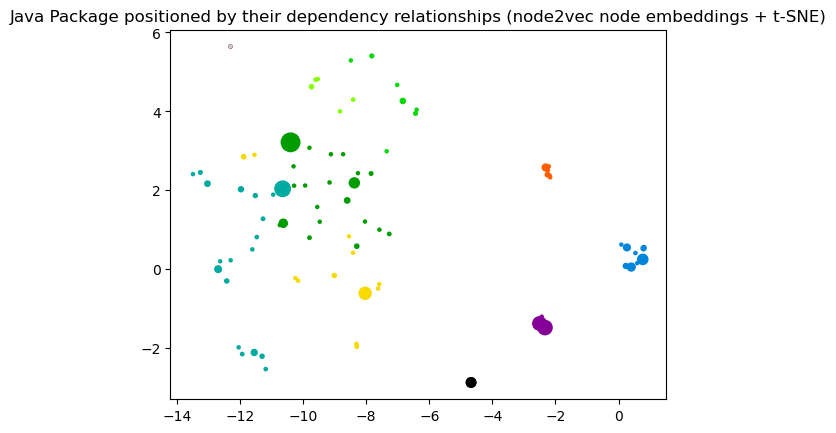

In [18]:
java_package_embeddings_parameters={
    "dependencies_projection": "java-package-embeddings-notebook",
    "dependencies_projection_node": "Package",
    "dependencies_projection_weight_property": "weight25PercentInterfaces",
    "dependencies_projection_write_property": "embeddingsNode2Vec",
    "dependencies_projection_embedding_dimension":"32"
}
embeddings = create_node_embeddings("../cypher/Node_Embeddings/Node_Embeddings_3d_Node2Vec_Stream.cypher", java_package_embeddings_parameters)
node_embeddings_for_visualization = prepare_node_embeddings_for_2d_visualization(embeddings)
plot_2d_node_embeddings(
    node_embeddings_for_visualization, 
    "Java Package positioned by their dependency relationships (node2vec node embeddings + t-SNE)"
)